A scaled down version of the VGG-16, with a few notable changes.

Number of convolution filters cut in half, fully connected (dense) layers scaled down.
Optimizer changed to RMSprop.
Output layer activation set to sigmoid for binary crossentropy.
Some layers commented out for efficiency.
The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset. (This script only trains on 8% of the 25K images. )

In [ ]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

# Train and Predict
I'm using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will overfit. I will also be tracking the loss history on each epoch to visualize the overfitting trend.

Note: A slice of 1000 images was used to fit the model for CPU efficency. The model's perfrmance improves significantly when used on the entire dataset.



In [ ]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

In [ ]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

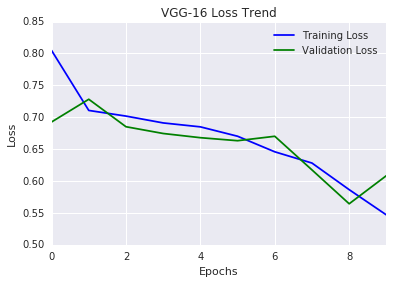

Run on the full dataset with a GPU for a LB logloss of ~0.4 and accuracy at approx 90%

In [ ]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

I am 91.20% sure this is a Dog

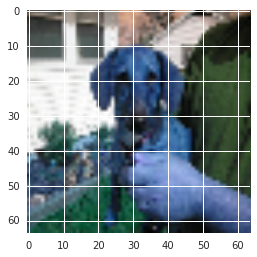